In [5]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
# from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import datetime
import importlib
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging.config
import logging
import sys, os
matplotlib.rcParams["figure.dpi"] = 150
client = Client()

/home/ashmat/cluster/LJ-magnetic/simulator/base.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
def standartize(arr):
    return (arr - np.mean(arr))/np.std(arr)

In [7]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 5.1')
                 .where(Simulation.Bz == 0)
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

5435


In [8]:
def f(sid):
    sim = SimulatorMagnetic(id=sid)
    dfs = sim.get_data_frames()
    TE = (dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1)

    if np.max(np.abs(TE-TE[0]))/TE[0] > 0.5:
        return None
    
    start = np.searchsorted(sim.get_history()["time"], 40)
    rs = sim.get_history()["rs"][start:].transpose(0,2,1).reshape(-1,3).T
    vs = sim.get_history()["vs"][start:].transpose(0,2,1).reshape(-1,3).T
    
    omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
    beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1
    
    return {"omega_MLE" : omega_MLE,
            "beta_MLE" : beta_MLE,
            "N" : sim.particle_number(),
            "L" : sim.angular_momentum(sim.r_init, sim.v_init)[2].sum(),
            "E" : sim.total_energy(sim.r_init, sim.v_init),
            "alpha" : sim.abc[0]**-1
           }

In [9]:
if "pool" in dir():
    pool.close()
    print("closed")
pool = Pool(cpu_count()-5, maxtasksperchild=1); pool

In [11]:
f(query[0])

{'omega_MLE': 0.36255422,
 'beta_MLE': 0.69441322086369,
 'N': 13,
 'L': 17.608545,
 'E': 62.55993660940651,
 'alpha': 1.0}

In [12]:
retult = list(tqdm(pool.imap(f, query[:]), total=len(query)))

100%|██████████| 5435/5435 [45:56<00:00,  1.97it/s]  


In [13]:
result = [x for x in retult if x is not None]
len(result)

5435

In [14]:
df = pd.DataFrame(result)

In [15]:
df["x"] = df.alpha * df.L / df.E
df["y_beta"] = 3 * df.N/df.E/df.beta_MLE
df["y_omega"] = df.omega_MLE * df.L / df.E

In [16]:
def f_beta(x):
    return 3 * (1 - x**2)/(2 + np.sqrt(1 + 3 * x**2))
def f_omega(x):
    return np.sqrt(1 + 3 * x**2) - 1

In [23]:
df[["x","y_beta","y_omega"]].to_csv("beta-omega-plot-data-ensemble-5.1.csv", index=False)

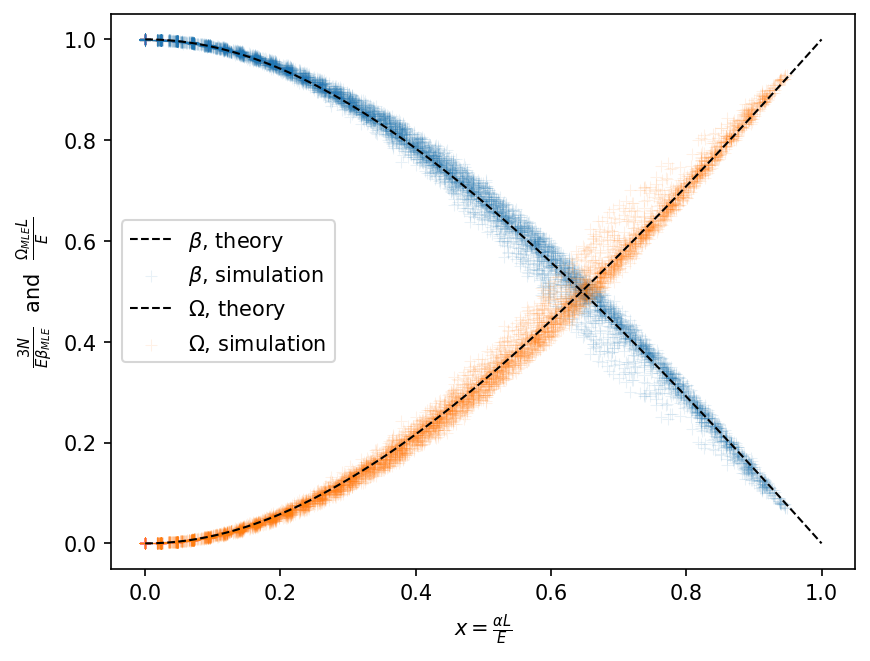

In [17]:
xs = np.linspace(0,1,100)
alpha=0.1
plt.plot(xs, f_beta(xs), "k--", lw=1, label=r"$\beta$, theory")
plt.scatter(df["x"], df["y_beta"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\beta$, simulation")

plt.plot(xs, f_omega(xs), "k--", lw=1, label="$\Omega$, theory")
plt.scatter(df["x"], df["y_omega"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\Omega$, simulation")


plt.xlabel(r"$x=\frac{\alpha L}{E}$")

plt.ylabel(r"$\frac{3 N}{ E \beta_{MLE} }$  and  $\frac{\Omega_{MLE} L}{E}$")
plt.legend()

In [55]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 4')
                 .where(Simulation.Bz == 0)
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

1001


In [56]:
np.random.shuffle(query)

In [57]:
sims = []
for sid in tqdm(query[:200]):
    sims.append(
        SimulatorMagnetic(id=sid)
    )

100%|██████████| 200/200 [03:04<00:00,  1.08it/s]


In [65]:
from relaxation.estimators import RelaxationFinder

In [76]:
type(np.array(sim.history["time"]))

numpy.ndarray

In [74]:
RelaxationFinder(sim, tmax=50)

100%|██████████| 250/250 [00:33<00:00,  7.53it/s]


In [78]:
_74.summarize()

{'col-1': 2.6690458486742235,
 'col-1.06': 2.145027459443018,
 'col-1.12': 1.8853360950398461,
 'csim-3': 0.018919693698265898,
 'csim-4': 0.42073266937120063,
 'csim-9': 0.1270243478348778,
 'csim-m': 0.15596793251040322,
 'rmsd': 1.7,
 'rmsv': 1.7}

In [58]:
data = []
rs = []
vs = []
for sim in tqdm(sims):
    start = np.searchsorted(sim.get_history()["time"], 40)
    rs.append(sim.get_history()["rs"][start:].transpose(0,2,1).reshape(-1,3))
    vs.append(sim.get_history()["vs"][start:].transpose(0,2,1).reshape(-1,3))
rs = np.concatenate(rs).T
vs = np.concatenate(vs).T

100%|██████████| 200/200 [00:18<00:00, 11.01it/s]


In [59]:
omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1

In [60]:
omega_MLE, beta_MLE

(0.7211846, 5.182780797792597)

In [61]:
residue = beta_MLE**0.5 * np.array([
    vs[0] + omega_MLE * rs[1],
    vs[1] - omega_MLE * rs[0],
    vs[2]
])

NormaltestResult(statistic=772.4643481867963, pvalue=1.8259885828406156e-168)

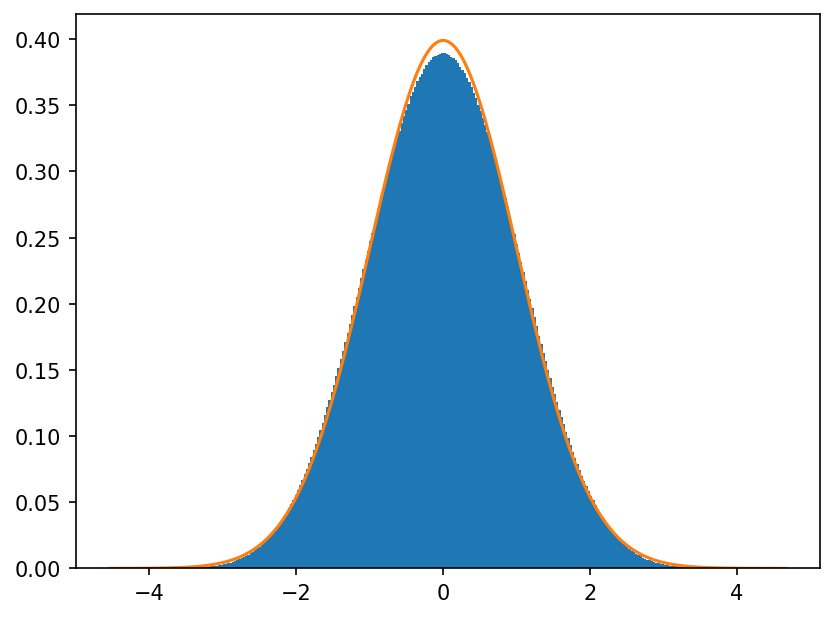

In [62]:
points = standartize(vs[0])
_,xs,_ = plt.hist(points, bins=300, density=1)
plt.plot(xs, norm.pdf(xs, loc=0, scale=1))
normaltest(residue[0])

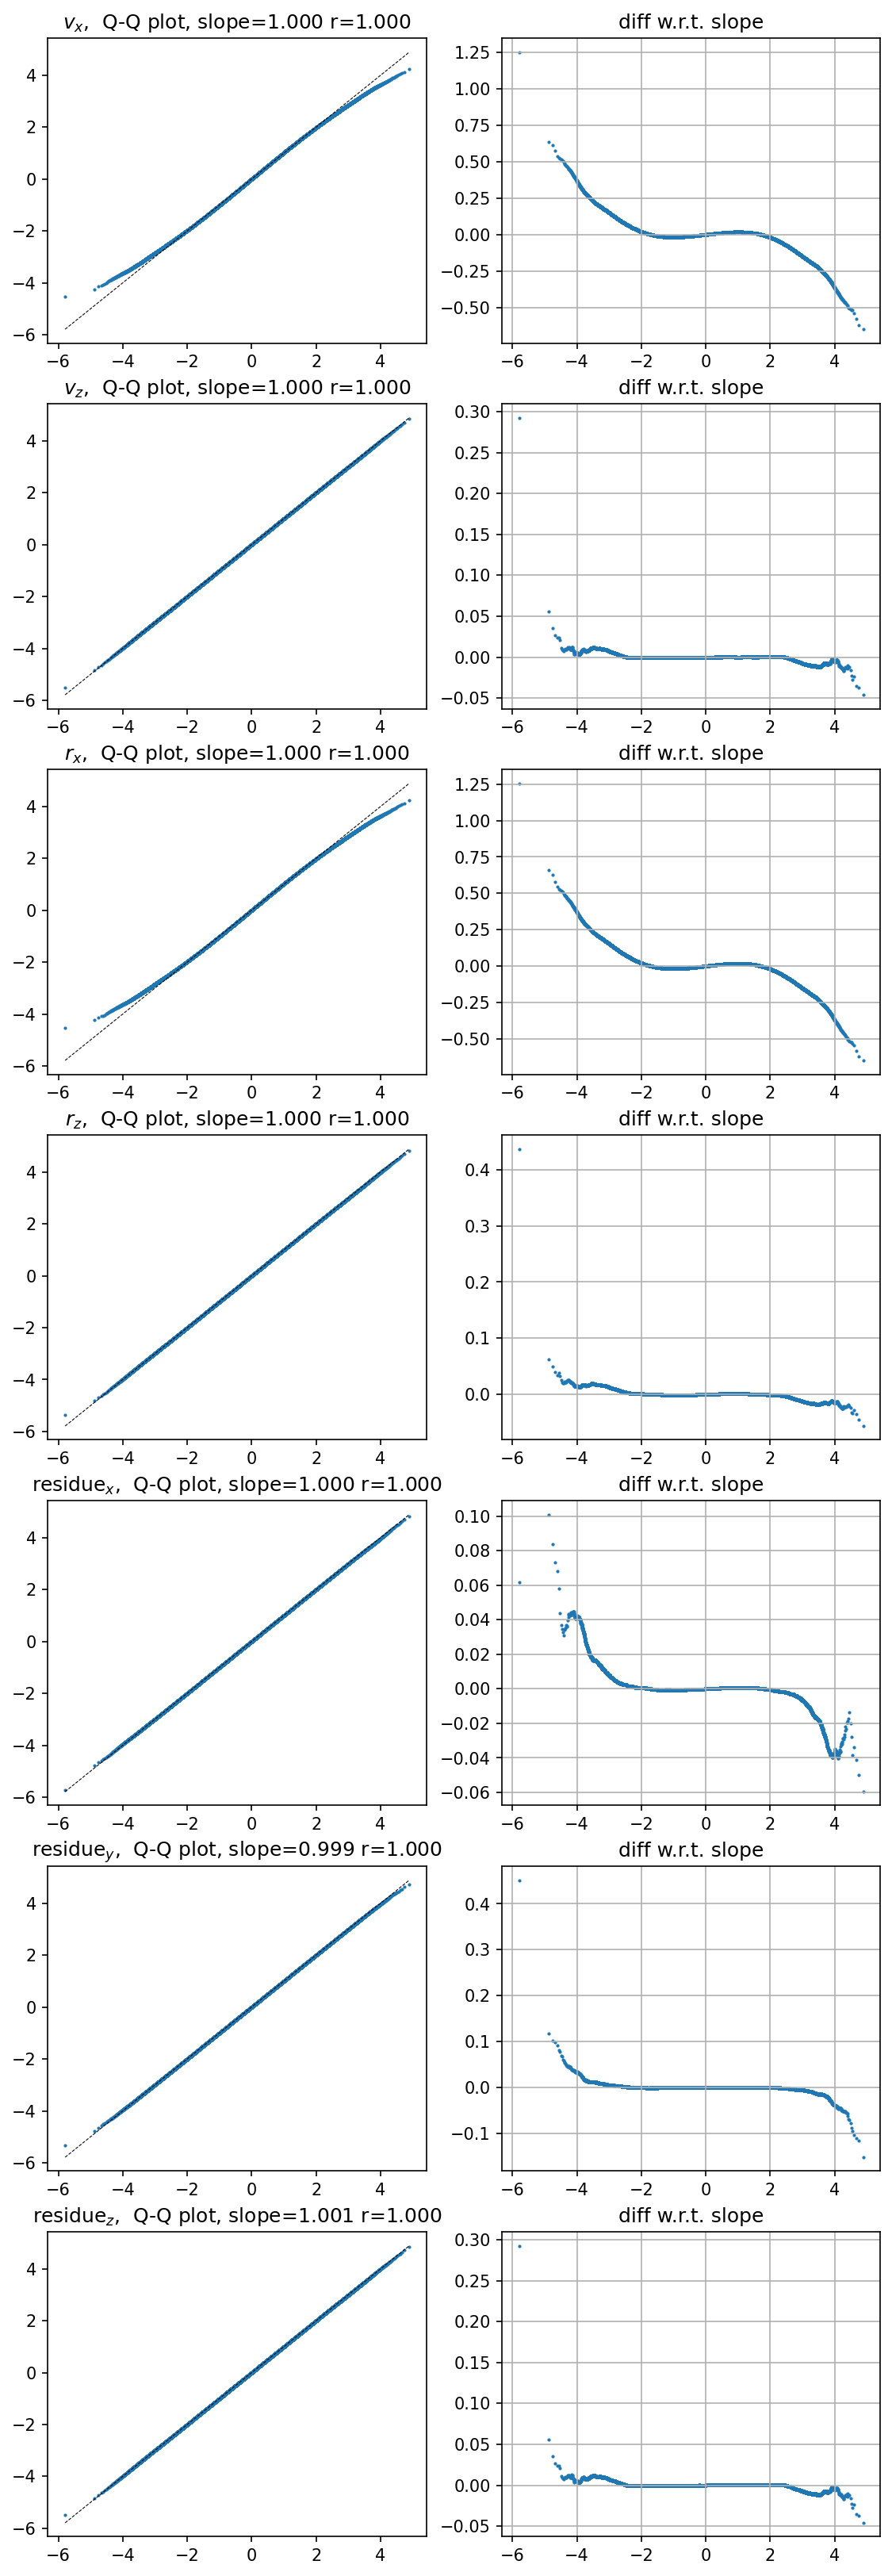

In [63]:
sp=100
plot_data = (
    [standartize(vs[0]), standartize(vs[2]), standartize(rs[0]), standartize(rs[2]), residue[0], residue[1], residue[2]],
    ["$v_x$", "$v_z$", "$r_x$", "$r_z$", "residue${}_x$", "residue${}_y$", "residue${}_z$"]
)
# plot_data = (
#     [standartize(vs[0]), standartize(vs[2])],
#     ["$v_x$", "$v_z$"]
# )
n_ = len(plot_data[0])
i_ = 1
plt.figure(figsize=(8,3 * n_))
for points, title in zip(*plot_data): 
    ((osm, osr), (slope, intercept, _r)) = probplot(points, dist="norm",)
    
    plt.subplot(n_, 2, i_);i_+=1
    plt.scatter(osm[::sp], osr[::sp], s=1)
    plt.plot(osm[::sp], osm[::sp] * slope + intercept, ls="--", c="k", lw=0.51)
    plt.title(title+",  "+f"Q-Q plot, slope={slope:0.3f} r={_r:0.3f}");
        
    plt.subplot(n_, 2, i_);i_+=1
    plt.title("diff w.r.t. slope")
    plt.scatter(osm[::sp], osr[::sp]-(osm[::sp] * slope + intercept), s=1)
    plt.grid()

plt.subplots_adjust(bottom=0, right=1, top=1)